<center><img src="car.jpg" width=500></center>


Insurance companies invest a lot of time and money into optimizing their pricing and accurately estimating the likelihood that customers will make a claim. In many countries it is a legal requirement to have car insurance in order to drive a vehicle on public roads, so the market is very large!

(`Source: https://www.accenture.com/_acnmedia/pdf-84/accenture-machine-leaning-insurance.pdf`) 

**Scenario:**, ***On the Road*** car insurance has requested your services in building a model to predict whether a customer will make a claim on their insurance during the policy period. As they have very little expertise and infrastructure for deploying and monitoring machine learning models, they've asked you to identify the single feature that results in the best performing model, as measured by accuracy, so they can start with a simple model in production.

### Objective

Identify the single feature of the data that is the best predictor of whether a customer will put in a claim (the "outcome" column), excluding the "id" column.

They have supplied you with their customer data as a csv file called `car_insurance.csv`, along with a table detailing the column names and descriptions below.



## The dataset

| Column | Description |
|--------|-------------|
| `id` | Unique client identifier |
| `age` | Client's age: <br> <ul><li>`0`: 16-25</li><li>`1`: 26-39</li><li>`2`: 40-64</li><li>`3`: 65+</li></ul> |
| `gender` | Client's gender: <br> <ul><li>`0`: Female</li><li>`1`: Male</li></ul> |
| `driving_experience` | Years the client has been driving: <br> <ul><li>`0`: 0-9</li><li>`1`: 10-19</li><li>`2`: 20-29</li><li>`3`: 30+</li></ul> |
| `education` | Client's level of education: <br> <ul><li>`0`: No education</li><li>`1`: High school</li><li>`2`: University</li></ul> |
| `income` | Client's income level: <br> <ul><li>`0`: Poverty</li><li>`1`: Working class</li><li>`2`: Middle class</li><li>`3`: Upper class</li></ul> |
| `credit_score` | Client's credit score (between zero and one) |
| `vehicle_ownership` | Client's vehicle ownership status: <br><ul><li>`0`: Does not own their vehilce (paying off finance)</li><li>`1`: Owns their vehicle</li></ul> |
| `vehcile_year` | Year of vehicle registration: <br><ul><li>`0`: Before 2015</li><li>`1`: 2015 or later</li></ul> |
| `married` | Client's marital status: <br><ul><li>`0`: Not married</li><li>`1`: Married</li></ul> |
| `children` | Client's number of children |
| `postal_code` | Client's postal code | 
| `annual_mileage` | Number of miles driven by the client each year |
| `vehicle_type` | Type of car: <br> <ul><li>`0`: Sedan</li><li>`1`: Sports car</li></ul> |
| `speeding_violations` | Total number of speeding violations received by the client | 
| `duis` | Number of times the client has been caught driving under the influence of alcohol |
| `past_accidents` | Total number of previous accidents the client has been involved in |
| `outcome` | Whether the client made a claim on their car insurance (response variable): <br><ul><li>`0`: No claim</li><li>`1`: Made a claim</li></ul> |

In [1]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit

In [2]:
df_car_ins = pd.read_csv("car_insurance.csv")
df_car_ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  int64  
 2   gender               10000 non-null  int64  
 3   driving_experience   10000 non-null  object 
 4   education            10000 non-null  object 
 5   income               10000 non-null  object 
 6   credit_score         9018 non-null   float64
 7   vehicle_ownership    10000 non-null  float64
 8   vehicle_year         10000 non-null  object 
 9   married              10000 non-null  float64
 10  children             10000 non-null  float64
 11  postal_code          10000 non-null  int64  
 12  annual_mileage       9043 non-null   float64
 13  vehicle_type         10000 non-null  object 
 14  speeding_violations  10000 non-null  int64  
 15  duis                 10000 non-null  

In [3]:
df_car_ins.head()

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,0,1,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,0,0,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,0,1,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,1,1,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


## `age`

Age is encoded as a categorical variable with 4 levels 0-4. These levels are ordinal in that the higher the level, the higher the age range being represented in that bucket. Because of this oridinality, we can treat these as continuous variables for analysis purposes.

| Column | Description |
|--------|-------------|
| `age` | Client's age: <br> <ul><li>`0`: 16-25</li><li>`1`: 26-39</li><li>`2`: 40-64</li><li>`3`: 65+</li></ul> |



In [4]:
# start by getting just the data we need for this predictor
df_age = df_car_ins.loc[:, ['age', 'outcome']]
df_age.head()

,age,outcome
0,3,0.0
1,0,1.0
2,0,0.0
3,0,0.0
4,1,1.0


In [5]:
# contingency table
pd.crosstab(df_age['age'], df_age['outcome'], margins=True)

outcome,0.0,1.0,All
age,,,
0,568,1448,2016
1,2031,1032,3063
2,2474,457,2931
3,1794,196,1990
All,6867,3133,10000


As we'd expect, the older the drive, the less likely they are to file a claim

In [6]:
threshold = 0.5  # make threshold explicit

mdl_age = logit("outcome ~ age", data=df_age).fit()

exploratory_data = pd.DataFrame({"age": np.arange(0, 5, 1)})
prediction_data = exploratory_data.assign(
    prob_filed = mdl_age.predict(exploratory_data)
)

prediction_data['pred_outcome'] = (prediction_data['prob_filed'] > threshold).astype(float)

Optimization terminated successfully.
         Current function value: 0.511794
         Iterations 6


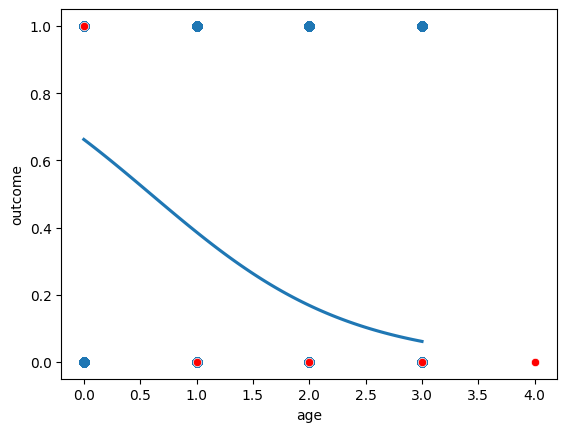

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x="age", 
            y="outcome", 
            data=df_age, 
            ci=None, 
            logistic=True)

sns.scatterplot(x="age", 
                y="pred_outcome", 
                data=prediction_data, 
                color="red")
plt.show() 

This plot looks like what we should expect: *as age increase, probability of making a claim drops*

In [8]:
# compute confusion matrix
df_age['prob_file'] = mdl_age.predict(df_age['age'])
df_age['pred_file'] = (df_age['prob_file'] > threshold).astype(float)
conf_matrix = mdl_age.pred_table()
print(conf_matrix)
# print(type(conf_matrix))

# extract TN, TP, FN and FP from confusion matix
def get_confusion_cells(conf_matrix):
    TN = conf_matrix[0, 0]
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    FP = conf_matrix[0, 1]
    return ((TN, TP, FN, FP))

def calc_accuracy(TN, TP, FN, FP):
    return ((TN + TP) / (TN + TP + FN +FP))

conf_cells = get_confusion_cells(conf_matrix)
accuracy_age = calc_accuracy(conf_cells[0], conf_cells[1], conf_cells[2], conf_cells[3])
print(f"\nAccuracy using age only: {accuracy_age}")

[[6299.  568.]
 [1685. 1448.]]

Accuracy using age only: 0.7747


## `gender`

Gender is a binary categorical variable.

| Column | Description |
|--------|-------------|
| `gender` | Client's gender: <br> <ul><li>`0`: Female</li><li>`1`: Male</li></ul> |

In [9]:
# start by getting just the data we need for this predictor
df_age = df_car_ins.loc[:, ['gender', 'outcome']]
# contingency table
contingency_table = pd.crosstab(df_age['gender'], df_age['outcome'], margins=True)
print(contingency_table)
contingency_table['prob_file'] = contingency_table[1.0] / contingency_table["All"]
# print(contingency_table.index)
# print(print(contingency_table.columns))
print(contingency_table)

outcome   0.0   1.0    All
gender                    
0        3689  1321   5010
1        3178  1812   4990
All      6867  3133  10000
outcome   0.0   1.0    All  prob_file
gender                               
0        3689  1321   5010   0.263673
1        3178  1812   4990   0.363126
All      6867  3133  10000   0.313300


Data suggest that women will file claims 26.4% of the time. Men will file 36.3% of the time. This is not a big difference, so we shouldn't expect this predictor to do very well.

In [10]:
mdl_gender = logit("outcome ~ gender", data=df_age).fit()

exploratory_data = pd.DataFrame({"gender": np.array([0, 1])})
prediction_data = exploratory_data.assign(
    prob_filed = mdl_gender.predict(exploratory_data)
)

prediction_data['pred_outcome'] = (prediction_data['prob_filed'] > threshold).astype(float)

Optimization terminated successfully.
         Current function value: 0.615951
         Iterations 5


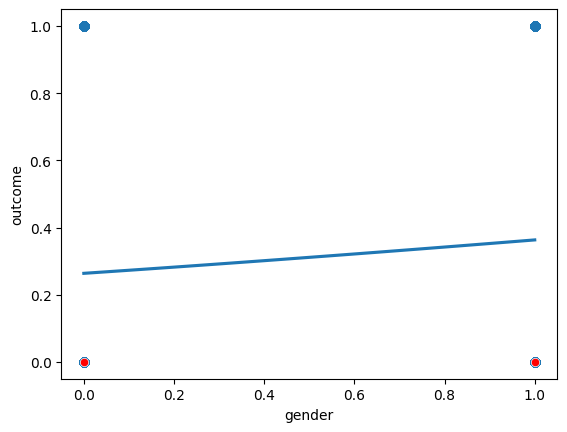

In [11]:
sns.regplot(x="gender", 
            y="outcome", 
            data=df_age, 
            ci=None, 
            logistic=True)

sns.scatterplot(x="gender", 
                y="pred_outcome", 
                data=prediction_data, 
                color="red")
plt.show() 

Looks a little funny because we're looking at a binary predictor, but is what we expect: *slightly high probability of filing if you are male*

In [14]:
# compute confusion matrix
df_age['prob_file'] = mdl_gender.predict(df_age['gender'])
df_age['pred_file'] = (df_age['prob_file'] > threshold).astype(float)
conf_matrix = mdl_gender.pred_table()
print(conf_matrix)  # neither gender shows > 50% probability of filing, so this is not going to be a useful predictor

[[6867.    0.]
 [3133.    0.]]


## `driving_experience`

Like `age`, `driving_experience` is encoded as a categorical variable with 4 levels 0-4. These levels are also ordinal in that the higher the level, the more driving exprience being represented in that bucket. Because of this oridinality, we can treat these as continuous variables for analysis purposes.

| Column | Description |
|--------|-------------|
| `driving_experience` | Years the client has been driving: <br> <ul><li>`0`: 0-9</li><li>`1`: 10-19</li><li>`2`: 20-29</li><li>`3`: 30+</li></ul> |